PLEASE DEMONSTRATE TAKING A TIME SERIES DATA PANDAS DATZFRAME CONVERTING IT TO TENSORFLOW DATASET TO FITTING IT AND RUNNG THE FORECAST

1. Prepare the Data

Let's start by creating a sample time series dataset in a Pandas DataFrame. We'll generate a simple synthetic dataset for illustration.

In [8]:
import pandas as pd
import numpy as np

# Generate synthetic monthly time series data
date_range = pd.date_range(start='2018-01-01', end='2024-12-01', freq='MS')
#data = np.sin(np.arange(len(date_range))) + np.random.normal(scale=0.1, size=len(date_range))
data = np.tanh(np.arange(len(date_range))) + np.random.normal(scale=0.1, size=len(date_range))
df = pd.DataFrame(data, index=date_range, columns=['value'])

# Display the first few rows
print(df.head())

               value
2018-01-01  0.002487
2018-02-01  0.918417
2018-03-01  0.869242
2018-04-01  1.013933
2018-05-01  0.913081


2. Preprocess the Data

Next, we'll preprocess the data by normalizing it and converting it into sequences suitable for training the model.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Create sequences for training
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_data, time_steps)


3. Convert to TensorFlow Dataset

Now, we convert the sequences into a TensorFlow Dataset for efficient training.

In [10]:
import tensorflow as tf

# Convert to TensorFlow Dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [11]:
'''

OPTIONAL

'''

# EXAMINE DATASET
for x, y in dataset.take(1):
    print(x.shape)
    print(y.shape)

(32, 12, 1)
(32, 1)


4. Build and Train the GRU Model

We'll build a simple GRU model and train it on the dataset.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Build the GRU model
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(time_steps, 1)),
    GRU(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 100
model.fit(dataset, epochs=epochs, verbose=1)


Epoch 1/100
3/3 [==============================] - 3s 11ms/step - loss: 0.8193
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.3652
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0911
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0728
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0737
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0132
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0210
Epoch 12/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 13/100
3/3 [==============================] - 0s 8ms/

5. Make Predictions

Finally, we'll forecast the next 12 months and inverse transform the predictions to their original scale.

In [13]:
# Prepare the input data for forecasting the next 12 months
forecast_input = scaled_data[-time_steps:].reshape(1, time_steps, 1)

# Forecast the next 12 months
forecasts = []
for _ in range(12):
    prediction = model.predict(forecast_input)
    forecasts.append(prediction[0, 0])
    
    # Update forecast_input: remove the first element and append the new prediction
    new_input = np.append(forecast_input[:, 1:, :], [[[prediction[0, 0]]]], axis=1)

    # Reshape the new input to maintain the correct dimensions
    forecast_input = new_input.reshape(1, time_steps, 1)

# Inverse transform the forecasts
forecasts = np.array(forecasts).reshape(-1, 1)
forecasts_original_scale = scaler.inverse_transform(forecasts)

# Display the forecasts
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_df = pd.DataFrame(forecasts_original_scale, index=forecast_dates, columns=['forecast'])
print(forecast_df)


            forecast
2025-01-01  1.013603
2025-02-01  1.008801
2025-03-01  1.007182
2025-04-01  1.007598
2025-05-01  1.008909
2025-06-01  1.010044
2025-07-01  1.011606
2025-08-01  1.013136
2025-09-01  1.013673
2025-10-01  1.015175
2025-11-01  1.015829
2025-12-01  1.016382


Explanation


Data Preparation: The data is first normalized using MinMaxScaler to fit within the range [0, 1]. Sequences are created using a sliding window approach, where each sequence consists of the past 12 months to predict the next month.

TensorFlow Dataset: The data is converted into a tf.data.Dataset for efficient batch processing and prefetching during training.

Model Architecture: A GRU model with two layers is used, followed by a Dense layer for output. The model is compiled with the adam optimizer and mean_squared_error loss.

Training and Forecasting: The model is trained for 100 epochs. For forecasting, the last 12 months of data are used to predict the next month iteratively for 12 months.

Inverse Transformation: After forecasting, the predictions are inverse transformed to the original scale to interpret the results.

This example demonstrates the entire process from data preparation to forecasting with a GRU model. Adjust the model's parameters, such as the number of units, epochs, and batch size, to better fit your specific dataset and requirements.

NameError: name 'mdates' is not defined

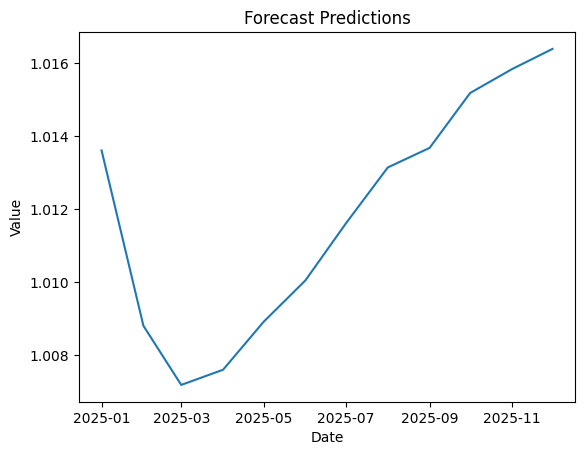

In [16]:
import matplotlib.pyplot as plt

import datetime

# Sample data to plot
dates = ['2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01']
values = [1.013603, 1.008801, 1.007182, 1.007598, 1.008909, 1.010044, 1.011606, 1.013136, 1.013673, 1.015175, 1.015829, 1.016382]

# Convert date strings to datetime objects
dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]

# Plotting a simple line chart using the above data
plt.plot(dates, values)

# Adding chart titles and axis labels
plt.title('Forecast Predictions')
plt.xlabel('Date')
plt.ylabel('Value')

# Formatting the x-axis ticks to display only years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotating the x-axis labels for better visibility
plt.xticks(rotation=45)

# Displaying the chart
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a dataframe for historical data
historical = pd.DataFrame({'date': ['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01'],
                           'value': [0.002487, 0.918417, 0.869242, 1.013933, 0.913081]})

# Create a dataframe for forecast data
forecast = pd.DataFrame({'date': ['2025-01-01', '2025-02-01 '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01'],
                         'value': [1.013603, 1.008801, 1.007182, 1.007598, 1.008909, 1.010044, 1.011606, 1.013136, .013673, 1.015175, 1.015829, 1.016382]})

# Convert date strings to datetime objects
historical['date'] = pd.to_datetime(historical['date'])
forecast[''] = pd.to_datetime(forecast['date'])

# Merge the two dataframes
merged = pd.concat([historical, forecast], ignore_index=True)

# Plotting a simple line chart using the above data
plt.plot(merged['date'], merged['value'])

# Adding chart titles and axis labels
plt.title('Historical and Forecast Predictions')
plt.xlabel('Date')
plt.ylabel('Value')

# Formatting the x-axis ticks to display only years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotating the x-axis labels for better visibility
plt.xticks(rotation=45)

# Displaying the chart
plt.show()

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (614447196.py, line 10)

In [14]:


  !!  IS UNNECK BC I THOT IT WAS NEEDED BC THER DUMM DATA IS MAD WEIRD BRO ITS ORIGINALLY MOSTLY -1.0 TO 1.0 MAD SURPRISING
         # Inverse transform the forecasts (Optional)


# from sklearn.preprocessing import MinMaxScaler
# import numpy as np
# import pandas as pd

# # Assuming 'scaler' is your MinMaxScaler object and 'forecasts' is your array of scaled predictions
# forecasts_scaled = np.array(forecasts).reshape(-1, 1)  # Ensure it's in the right shape for scaling
# forecasts_original = scaler.inverse_transform(forecasts_scaled)  # Convert back to original scale

# # Creating a DataFrame for display
# forecast_dates = pd.date_range(start='2025-01-01', periods=len(forecasts), freq='MS')  # Adjust the start date as needed
# forecast_df = pd.DataFrame(forecasts_original, index=forecast_dates, columns=['Forecast'])
# print(forecast_df)


["'IS' is not recognized as an internal or external command,",
 'operable program or batch file.']